# Kaggle - Allstate Claim Severity - [LINK](https://www.kaggle.com/competitions/allstate-claims-severity/data) 

## EDA v2

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels as sm
import xgboost as xgb

import plotly.figure_factory as ff
import plotly.express as px
import sklearn.preprocessing as sklpp

In [47]:
import os
import gc
import warnings

### Goals 
- **Import & basic preparation**

- **Data cleaning**
    - Outliers
    - Missing values
    - Duplicate data
    - Data Quality Measures
        - Accuracy
        - Completeness
        - Timeliness
        - Believability
        - Interoperability

- **Graphs** *(mean, median, mode, ...)*
    - Correlation Map
    - Boxplot
    - Histogram
    - Quantile Plot
    - Scatter Plot (correlation)

### Matt Objective Updates

1. Identify
    - *Target*
    - *Predictors* & their *Exposure*

2. Visuals of *Predictors* & *Target*

3. Frequency tables for *Categorical/Nominal* *Predictors*

4. Start creating different models (in different notebooks)

## (1) Import & Basic Preparation

In [48]:
PATH = os.getcwd()
print(PATH)
PATH = PATH.split('/')[:-1]
PATH = ''.join([str(folder + '/') for folder in PATH])
print(PATH)

/Users/education/Documents/Github Repos/Personal/Datasets_EDA/src/Allstate Claims Severity/code
/Users/education/Documents/Github Repos/Personal/Datasets_EDA/src/Allstate Claims Severity/


#### (1.i)
*'train.csv'* file does go on longer then line 188,320. But there appears to be some formatting issue after that line. I tried to write a separate python file that can add line by line of *'train.csv'* into a Panda's Dataframe but that seem to take to long. So I'll use up to 188,320 for now.

In [49]:
train_df = pd.read_csv(
    filepath_or_buffer= os.path.join(PATH, 'train.csv'),
    on_bad_lines= 'skip' # issue on line 188320
)

Removing the last line in the dataframe that is part of the issue I mentioned above ^. 

In [50]:
print(train_df.iloc[188317:188319]) # need to drop 188318 as it doesn't fit with data 

                   id      cat1      cat2      cat3      cat4      cat5  \
188317  587633.000000         B         A         A         B         A   
188318       0.348388   .672862   .551054   .344450   .447670   .538810   

            cat6      cat7      cat8      cat9  ...     cont6     cont7  \
188317         A         A         A         A  ...  0.844563  0.533048   
188318   .492200   .481306   .654753   .406237  ...       NaN       NaN   

          cont8    cont9   cont10    cont11    cont12    cont13   cont14  \
188317  0.97123  0.93383  0.83814  0.932195  0.946432  0.810511  0.72146   
188318      NaN      NaN      NaN       NaN       NaN       NaN      NaN   

           loss  
188317  4751.72  
188318      NaN  

[2 rows x 132 columns]


In [51]:
train_df.drop(
    inplace= True,
    index= 188318,
    axis= 'index'
)
print(train_df.iloc[188317:188319]) # need to drop 188318 as it doesn't fit with data

              id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont6  \
188317  587633.0    B    A    A    B    A    A    A    A    A  ...  0.844563   

           cont7    cont8    cont9   cont10    cont11    cont12    cont13  \
188317  0.533048  0.97123  0.93383  0.83814  0.932195  0.946432  0.810511   

         cont14     loss  
188317  0.72146  4751.72  

[1 rows x 132 columns]


In [52]:
print(train_df.head(5))

     id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9  ...     cont6     cont7  \
0   1.0    A    B    A    B    A    A    A    A    B  ...  0.718367  0.335060   
1   2.0    A    B    A    A    A    A    A    A    B  ...  0.438917  0.436585   
2   5.0    A    B    A    A    B    A    A    A    B  ...  0.289648  0.315545   
3  10.0    B    B    A    B    A    A    A    A    B  ...  0.440945  0.391128   
4  11.0    A    B    A    B    A    A    A    A    B  ...  0.178193  0.247408   

     cont8    cont9   cont10    cont11    cont12    cont13    cont14     loss  
0  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493  0.714843  2213.18  
1  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431  0.304496  1283.60  
2  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709  0.774425  3005.09  
3  0.31796  0.32128  0.44467  0.327915  0.321570  0.605077  0.602642   939.85  
4  0.24564  0.22089  0.21230  0.204687  0.202213  0.246011  0.432606  2763.85  

[5 rows x 132 columns]


In [53]:
print(train_df.shape)

(188318, 132)


#### (1.ii)
Defining constants for later use.

In [54]:
X_CAT = [str('cat' + str(i)) for i in range(1, 117, 1)]
X_CONT = [str('cont' + str(i)) for i in range(1, 15, 1)]
Y = 'loss'

CAT_X_Y, CONT_X_Y = X_CAT.copy(), X_CONT.copy()
CAT_X_Y.append(Y)
CONT_X_Y.append(Y)

#### (1.iii)
Setting datatype's of attributes/features/columns.

In [55]:
print(train_df.dtypes)

id        float64
cat1       object
cat2       object
cat3       object
cat4       object
           ...   
cont11    float64
cont12    float64
cont13    float64
cont14    float64
loss      float64
Length: 132, dtype: object


In [56]:
# https://pandas.pydata.org/pandas-docs/stable/user_guide/basics.html#basics-dtypes

train_df['id'].astype('int32')
train_df['loss'].astype('float32')
train_df[X_CAT].astype('string')
train_df[X_CONT].astype('float32')
print(train_df.dtypes)

id        float64
cat1       object
cat2       object
cat3       object
cat4       object
           ...   
cont11    float64
cont12    float64
cont13    float64
cont14    float64
loss      float64
Length: 132, dtype: object


## (2) Data Cleaning

- Missing values
- Duplicate data
- Outliers
- Data Quality Measures
    - Accuracy
    - Completeness
    - Timeliness
    - Believability
    - Interoperability

In [57]:
gc.collect()

44534

#### (2.a) Missing Data

In [58]:
null_rows = train_df.isnull().any(axis=1)
print(null_rows.describe()) # seems to be no missing data

count     188318
unique         1
top        False
freq      188318
dtype: object


#### (2.b) Duplicate Rows

In [59]:
dup_rows = train_df.duplicated()
print(dup_rows.describe()) # no duplicates

count     188318
unique         1
top        False
freq      188318
dtype: object


#### (2.c) Remove Outliers

(2.c.i) Categorical Outliers

In [60]:
for col_name, col in train_df[X_CAT].items():
    num_rows = col.shape[0]
    freq = col.value_counts()
    freq = list(freq.items())
    freq = [(name, (num*100)/num_rows) for name, num in freq]
    
    print(freq)


[('A', 75.16541169723553), ('B', 24.834588302764473)]
[('A', 56.6706315912446), ('B', 43.3293684087554)]
[('A', 94.51725273208085), ('B', 5.482747267919158)]
[('A', 68.1798872120562), ('B', 31.820112787943795)]
[('A', 65.70641149544919), ('B', 34.29358850455081)]
[('A', 69.93118023768307), ('B', 30.06881976231693)]
[('A', 97.5711296848947), ('B', 2.428870315105301)]
[('A', 94.13545173589354), ('B', 5.864548264106459)]
[('A', 60.069669389012205), ('B', 39.930330610987795)]
[('A', 85.07577608088447), ('B', 14.924223919115539)]
[('A', 89.3095721067556), ('B', 10.690427893244406)]
[('A', 84.8697416072813), ('B', 15.1302583927187)]
[('A', 89.6626982019775), ('B', 10.337301798022494)]
[('A', 98.79087500929279), ('B', 1.209124990707208)]
[('A', 99.9819454327255), ('B', 0.018054567274503764)]
[('A', 96.56166696757612), ('B', 3.4383330324238788)]
[('A', 99.30489915993161), ('B', 0.6951008400683949)]
[('A', 99.47588653235485), ('B', 0.5241134676451534)]
[('A', 99.03992183434403), ('B', 0.9600781

(2.c.ii) Continuous Outliers

In [61]:
std_max = 3
show_image = True

'loss' removing 3524 thats 3x away from mean. 0.02%


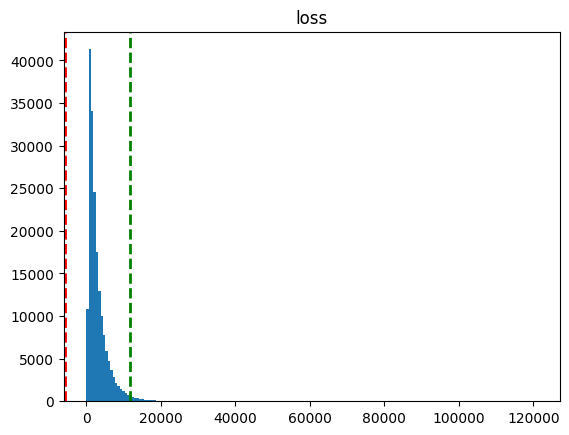

In [62]:
# https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/

for col_name, col in train_df[CONT_X_Y].items():
    initial_rows = col.shape[0]
    
    col_mean, col_std = col.mean(), col.std()    
    lower_b, upper_b = col_mean - (col_std * std_max), col_mean + (col_std * std_max)

    col_tf = (col < lower_b) | (col > upper_b)
    num_rows_remove = col_tf[col_tf == True].count()
    
    if num_rows_remove > 0:
        print(f"\'{col_name}\' removing {num_rows_remove} thats {std_max}x away from mean. {(num_rows_remove/initial_rows):2.2f}%")
        
        train_df.drop(
            index= train_df[col_tf].index,
            axis= 0,
            inplace= True
        )
        
        if show_image == True:
            fig = plt.hist(
                x= col,
                bins= int(len(col) / 1000)
            )
            plt.axvline(
                x= lower_b,
                color= 'r',
                linestyle= '--',
                linewidth= 2
            )
            plt.axvline(
                x= upper_b,
                color= 'g',
                linestyle= '--',
                linewidth= 2
            )
            plt.title(label= col_name)
            plt.show()

#### (2.d) Data Quality Measures
- Accuracy
- Completeness
- Timeliness
- Believability
- Interoperability

Not knowing what the columns are makes it hard to preform this assessment.

## (3) Graphs
- Correlation Map
- Boxplot
- Histogram
- Quantile Plot
- Scatter Plot (correlation)
- Mean, Median, Mode, etc...

In [63]:
train_df[CONT_X_Y].corr(method='pearson')

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
cont1,1.000000,-0.086084,-0.445739,0.367092,-0.026904,0.758448,0.372800,0.360784,0.929662,0.808882,0.600279,0.618301,0.533174,0.056446,-0.022555
cont2,-0.086084,1.000000,0.455022,0.040079,0.193995,0.013180,0.042289,0.136785,-0.034071,0.062029,0.112586,0.101999,0.023603,-0.046239,0.107156
cont3,-0.445739,0.455022,1.000000,-0.341046,0.093218,-0.353002,0.088480,-0.186067,-0.418210,-0.327669,0.018320,-0.000701,-0.416981,-0.040542,0.081097
cont4,0.367092,0.040079,-0.341046,1.000000,0.162806,0.221918,-0.110908,0.528736,0.328723,0.283136,0.123252,0.132614,0.177661,0.017719,-0.029570
cont5,-0.026904,0.193995,0.093218,0.162806,1.000000,-0.150689,-0.248216,0.008442,-0.089954,-0.066179,-0.150728,-0.147246,-0.086051,-0.021885,-0.001851
cont6,0.758448,0.013180,-0.353002,0.221918,-0.150689,1.000000,0.662385,0.438284,0.797736,0.883356,0.776231,0.787610,0.816465,0.042130,0.007888
cont7,0.372800,0.042289,0.088480,-0.110908,-0.248216,0.662385,1.000000,0.144777,0.388290,0.496550,0.746581,0.742365,0.296531,0.021866,0.054381
cont8,0.360784,0.136785,-0.186067,0.528736,0.008442,0.438284,0.144777,1.000000,0.452759,0.336292,0.304546,0.317945,0.477875,0.043995,0.020427
cont9,0.929662,-0.034071,-0.418210,0.328723,-0.089954,0.797736,0.388290,0.452759,1.000000,0.785928,0.611497,0.630063,0.642154,0.073942,-0.000910
cont10,0.808882,0.062029,-0.327669,0.283136,-0.066179,0.883356,0.496550,0.336292,0.785928,1.000000,0.705597,0.716464,0.707548,0.041601,-0.006588


Correlation Map

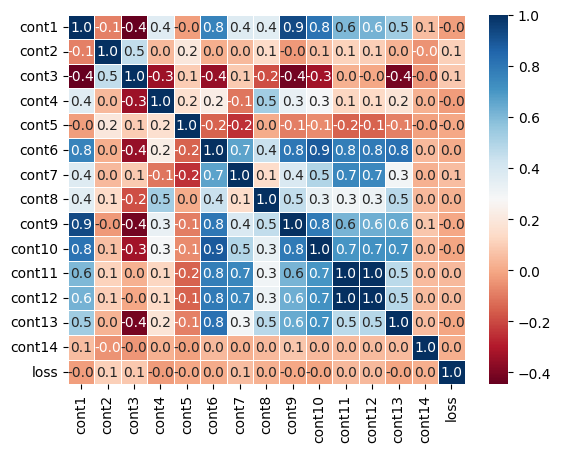

In [64]:
# https://seaborn.pydata.org/generated/seaborn.heatmap.html#seaborn.heatmap
sns.heatmap(
    data= train_df[CONT_X_Y].corr(method='pearson'),
    annot= True,
    cmap= 'RdBu', # https://matplotlib.org/stable/users/explain/colors/colormaps.html
    fmt= '.1f',
    linewidth= .5,
    # vmin= -1,
    # vmax= 1
)
plt.show()

Continuous Columns Correlation Box Plot

In [65]:
num_samples = int(train_df.shape[0] / 500)
train_sample_df = train_df.sample(
    n = num_samples,
    axis= 0
)

In [66]:
# https://plotly.com/python/box-plots/

import plotly.graph_objects as go

fig = go.Figure()
for lab, col in train_sample_df[X_CONT].items():
    fig.add_trace(go.Box(
        y=col,
        name= lab,
        visible= 'legendonly'
        )
    )
fig.show()

Scatter Plot

In [70]:
fig = go.Figure()
fig = px.scatter(
    data_frame= train_sample_df[CONT_X_Y],
    x= X_CONT,
    y= 'loss',
    render_mode= 'webgl'
)
fig.show()

## Matt Objective Updates

1. Identify
    - *Target*
    - *Predictors* & their *Exposure*

2. Visuals of *Predictors* & *Target*

3. Frequency tables for *Categorical/Nominal* *Predictors*

4. Start creating different models (in different notebooks)

In [71]:
# https://www.kaggle.com/competitions/allstate-claims-severity/overview